In [1]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import HashingTF, IDF, StringIndexer, SQLTransformer,IndexToString
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator#
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import Word2Vec
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import sys,os,os.path
import json
import pyspark.sql.types as T
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report



In [2]:

# os.environ['SPARK_HOME'] = r'C:\spark'
# os.environ['HADOOP_HOME '] = r'C:\hadoop'
os.environ['PYSPARK_DRIVER_PYTHON'] = 'jupyter'
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = 'notebook'
os.environ['PYSPARK_PYTHON'] = 'python'
# os.environ['JAVA_HOME'] = r'C:\java'

In [3]:
spark = SparkSession.builder \
    .appName("Spark NLP")\
    .master("local[4]")\
    .config("spark.memory.offHeap.enabled","true") \
    .config("spark.memory.offHeap.size","10g")\
    .config("spark.driver.memory","16G")\
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:4.0.2")\
    .getOrCreate()

In [4]:
# get path of the data files
notebook_path = os.path.abspath("classifier_spark.ipynb")
files_path = os.path.dirname(notebook_path)+'\\lonely\\'

In [215]:
# read all the json files
data = spark.read.json(os.path.dirname(files_path+'*.json'))


In [41]:
document_assembler = DocumentAssembler() \
.setInputCol("agg_text") \
.setOutputCol("document") \
.setCleanupMode("shrink") # removes new lines, tabs, and merges multiple blank spaces into one space

tokenizer = Tokenizer().setInputCols(["document"]) \
.setOutputCol("token") \
.setSplitChars(['-']) \
.setContextChars(['(', ')', '?', '!', '#', '@'])

normalizer = Normalizer() \
.setInputCols(["token"]) \
.setOutputCol("normalized")\
.setCleanupPatterns(["[^\w\d\s]"]) 

stopwords_cleaner = StopWordsCleaner()\
.setInputCols("normalized")\
.setOutputCol("cleanTokens")\
.setCaseSensitive(False)

# lemma = LemmatizerModel.pretrained('lemma_antbnc') \
# .setInputCols(["cleanTokens"]) \
# .setOutputCol("lemma")

stemmer = Stemmer() \
    .setInputCols(["cleanTokens"]) \
    .setOutputCol("stem")# Convert custom document structure to array of tokens.
finisher = Finisher() \
    .setInputCols(["stem"]) \
    .setOutputCols(["token_features"]) \
    .setOutputAsArray(True) \
    .setCleanAnnotations(False)# 

token_pipeline = Pipeline(
    stages=[document_assembler, 
            tokenizer,
            normalizer,
            stopwords_cleaner, 
            stemmer,
            finisher]
)

In [42]:
# lemma = LemmatizerModel.pretrained('lemma_antbnc') \
# .setInputCols(["cleanTokens"]) \
# .setOutputCol("lemma")

stemmer = Stemmer() \
    .setInputCols(["normalized"]) \
    .setOutputCol("stem")# Convert custom document structure to array of tokens.
finisher = Finisher() \
    .setInputCols(["stem"]) \
    .setOutputCols(["token_features"]) \
    .setOutputAsArray(True) \
    .setCleanAnnotations(False)# 
token_pipeline_with_Stop = Pipeline(
    stages=[document_assembler, 
            tokenizer,
            normalizer,
            stemmer,
            finisher]
)

In [207]:
token_model =  token_pipeline.fit(data)  
token_model_with_stop =  token_pipeline_with_Stop.fit(data)  


In [47]:
df2 = token_model.transform(data)
df2 = df2.select('lonely_indicator',F.explode(df2.token_features))
# word_counts_0 = df2.groupBy(['col','lonely_indicator']).count().sort(F.desc("count")).limit(50).select('col','count')
word_counts_1 = df2.filter(df2.lonely_indicator=='0').groupBy(['col']).count().sort(F.desc("count")). limit(50).select('col','count')
word_counts_0 = df2.filter(df2.lonely_indicator=='1').groupBy(['col']).count().sort(F.desc("count")). limit(50).select('col','count')

word_clouds_0 = word_counts_0.join(df2,on='col',how='left')
word_clouds_1 = word_counts_1.join(df2,on='col',how='left')

In [48]:
word_counts_0.show(10)

+----+-----+
| col|count|
+----+-----+
|  im|  201|
|like|  170|
|dont|  113|
| lol|  112|
|your|  109|
|love|  108|
| get|  107|
|know|  106|
|  go|   97|
|   u|   86|
+----+-----+
only showing top 10 rows



In [49]:
word_counts_1.show(10)

+--------+-----+
|     col|count|
+--------+-----+
|      im|   27|
|_kaoirb_|   17|
|    like|   15|
|    dont|   13|
|   thank|   12|
|      go|   11|
|     lol|   10|
|       u|   10|
|   bitch|   10|
|      oh|    8|
+--------+-----+
only showing top 10 rows



In [50]:
words_0 = word_clouds_0.rdd.map(lambda x:x['col']).collect()
words_1 = word_clouds_1.rdd.map(lambda x:x['col']).collect()
words_0 = " ".join(w for w in words_0)
words_1 = " ".join(w for w in words_1)

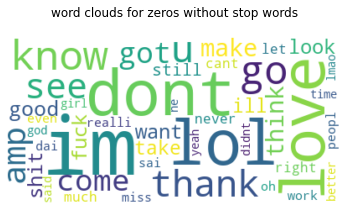

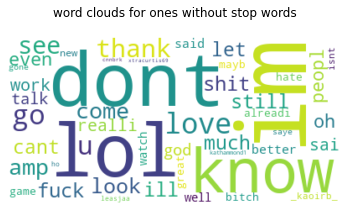

In [51]:

word_img_0 = WordCloud(collocations = False, background_color = 'white').generate(words_0)
word_img_1 = WordCloud(collocations = False, background_color = 'white').generate(words_1)

plt.imshow(word_img_0, interpolation='bilinear')
plt.title('word clouds for zeros without stop words\n')
plt.axis("off")
plt.show()

plt.imshow(word_img_1, interpolation='bilinear')
plt.title('word clouds for ones without stop words\n')
plt.axis("off")
plt.show()

In [52]:
df2 = token_model_with_stop.transform(data)
df2 = df2.select('lonely_indicator',F.explode(df2.token_features))
# word_counts_0 = df2.groupBy(['col','lonely_indicator']).count().sort(F.desc("count")).limit(50).select('col','count')
word_counts_1 = df2.filter(df2.lonely_indicator=='0').groupBy(['col']).count().sort(F.desc("count")). limit(50).select('col','count')
word_counts_0 = df2.filter(df2.lonely_indicator=='1').groupBy(['col']).count().sort(F.desc("count")). limit(50).select('col','count')

word_clouds_0 = word_counts_0.join(df2,on='col',how='left')
word_clouds_1 = word_counts_1.join(df2,on='col',how='left')

In [53]:
word_counts_0.show(10)

+----+-----+
| col|count|
+----+-----+
|   i| 1094|
| you|  629|
| the|  583|
|   a|  518|
|  to|  508|
| and|  414|
|  it|  405|
|that|  307|
|  of|  249|
|  my|  245|
+----+-----+
only showing top 10 rows



In [54]:
word_counts_1.show(10)

+---+-----+
|col|count|
+---+-----+
|  i|   87|
|you|   51|
|the|   45|
| to|   40|
|  a|   39|
| it|   38|
|and|   33|
| im|   27|
| on|   23|
| my|   23|
+---+-----+
only showing top 10 rows



In [55]:
words_0 = word_clouds_0.rdd.map(lambda x:x['col']).collect()
words_1 = word_clouds_1.rdd.map(lambda x:x['col']).collect()
words_0 = " ".join(w for w in words_0)
words_1 = " ".join(w for w in words_1)

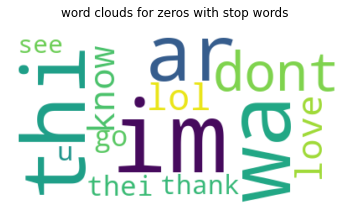

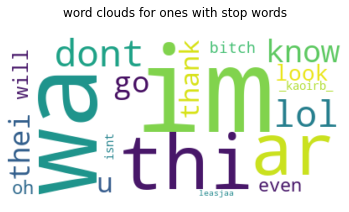

In [56]:

word_img_0 = WordCloud(collocations = False, background_color = 'white').generate(words_0)
word_img_1 = WordCloud(collocations = False, background_color = 'white').generate(words_1)

plt.imshow(word_img_0, interpolation='bilinear')
plt.title('word clouds for zeros with stop words\n')
plt.axis("off")
plt.show()

plt.imshow(word_img_1, interpolation='bilinear')
plt.title('word clouds for ones with stop words\n')
plt.axis("off")
plt.show()

In [216]:
traindatset, testdataset = data.randomSplit([0.7, 0.3],seed=42) # split to train and validation
token_model =  token_pipeline.fit(traindatset)  
traindatset = token_model.transform(traindatset) # transform the agg_text to clean tokens
testdataset = token_model.transform(testdataset) # transform the agg_text to clean tokens

In [217]:
classes_count = data.groupby('lonely_indicator').count().toPandas() # calculate the class balance ratio

BalancingRatio =  classes_count['count'][0]/classes_count['count'].sum()
# add the class balance column to train dataset
traindatset = traindatset.withColumn("classWeights", F.when(traindatset.lonely_indicator == 0,BalancingRatio).otherwise(1-BalancingRatio))


In [218]:

cols = traindatset.columns
cols.remove('lonely_indicator')
cols.remove('agg_text')
cols.remove('actor_id')
cols.remove('classWeights')
cols.remove('document')
cols.remove('token')
cols.remove('normalized')
cols.remove('cleanTokens')
cols.remove('stem')
cols.remove('token_features')
# cols.remove('rawFeatures')
# cols.remove('features1')
# Create an assembler object
assembler = VectorAssembler(inputCols=cols, outputCol='features') # assemble all the training column into one vector

In [219]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'lonely_indicator',seed=42) # use brute force randomforest
rf.setWeightCol('classWeights')

rf_pip = Pipeline(
    stages=[assembler,rf])
rf_fit  = rf_pip.fit(traindatset)

In [220]:
predictions_no_text =  rf_fit.transform(testdataset)
predictions_no_text.groupby(["prediction","lonely_indicator"]).count().show()

+----------+----------------+-----+
|prediction|lonely_indicator|count|
+----------+----------------+-----+
|       1.0|             1.0|  113|
|       0.0|             1.0|   11|
|       1.0|             0.0|   21|
|       0.0|             0.0|    4|
+----------+----------------+-----+



In [221]:

preds = predictions_no_text.select(["lonely_indicator","prediction"]).toPandas()
print (classification_report( preds["lonely_indicator"],preds["prediction"],zero_division='warn'))

              precision    recall  f1-score   support

         0.0       0.27      0.16      0.20        25
         1.0       0.84      0.91      0.88       124

    accuracy                           0.79       149
   macro avg       0.55      0.54      0.54       149
weighted avg       0.75      0.79      0.76       149



<AxesSubplot:>

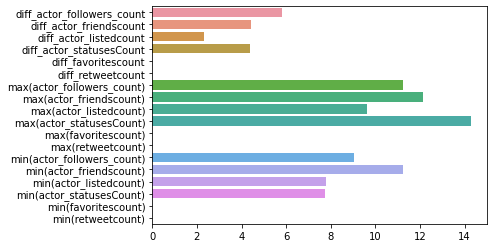

In [222]:
# plot the importance of every column of the original dataset 
rf_classifier = rf_fit.stages[-1]
sns.barplot(x= rf_classifier.featureImportances.toArray()[:18]*100,y=cols[:18])


In [223]:
f_import = rf_classifier.featureImportances.toArray()[:18]
new_cols = np.array(cols[:18])[np.argsort(f_import)[::-1]][:5] # get the most important columns

In [224]:
assembler = VectorAssembler(inputCols=new_cols, outputCol='features') # assemble all the training column into one vector
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'lonely_indicator',seed=42) # use brute force randomforest
rf.setWeightCol('classWeights')

rf_pip = Pipeline(
    stages=[assembler,rf])
rf_fit  = rf_pip.fit(traindatset)

In [225]:
predictions_5 =  rf_fit.transform(testdataset)
predictions_5.groupby(["prediction","lonely_indicator"]).count().show()

+----------+----------------+-----+
|prediction|lonely_indicator|count|
+----------+----------------+-----+
|       1.0|             1.0|  114|
|       0.0|             1.0|   10|
|       1.0|             0.0|   20|
|       0.0|             0.0|    5|
+----------+----------------+-----+



In [226]:

preds_no_text = predictions_no_text.select(["lonely_indicator","prediction"]).toPandas()
preds_5 = predictions_5.select(["lonely_indicator","prediction"]).toPandas()

print("using all the 18 features and without using the text column\n")
print (classification_report( preds_no_text["lonely_indicator"],preds_no_text["prediction"],zero_division='warn'))
print("using the 5 most important features and without using the text column\n")
print (classification_report( preds_5["lonely_indicator"],preds_5["prediction"],zero_division='warn'))

using all the 18 features and without using the text column

              precision    recall  f1-score   support

         0.0       0.27      0.16      0.20        25
         1.0       0.84      0.91      0.88       124

    accuracy                           0.79       149
   macro avg       0.55      0.54      0.54       149
weighted avg       0.75      0.79      0.76       149

using the 5 most important features and without using the text column

              precision    recall  f1-score   support

         0.0       0.33      0.20      0.25        25
         1.0       0.85      0.92      0.88       124

    accuracy                           0.80       149
   macro avg       0.59      0.56      0.57       149
weighted avg       0.76      0.80      0.78       149



In [227]:

# to generate term frequenct
hashingTF = HashingTF(inputCol="token_features", outputCol="rawFeatures", numFeatures=400)

# To generate Inverse Document Frequency
idf = IDF(inputCol="rawFeatures", outputCol="features1", minDocFreq=5) 

# convert labels (string) to integers. Easy to process compared to string.
# label_stringIdx = StringIndexer(inputCol = "lonely_indicator", outputCol = "label")

# define a simple Multinomial logistic regression model. Try different combination of hyperparameters and see what suits your data. You can also try different algorithms and compare the scores.
# lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.0,labelCol="lonely_indicator")
# lr.setWeightCol("classWeights")

#To convert index(integer) to corresponding class labels
# label_to_stringIdx = IndexToString(inputCol="label", outputCol="article_class")# define the nlp pipeline

tdfidf_pipeline = Pipeline(
    stages=[
            hashingTF,
            idf

            ])

In [228]:
# train the random forest with agg_text column encoded 
cols.append('features1')
assembler1 = VectorAssembler(inputCols=cols, outputCol='features')
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'lonely_indicator',seed=42)
rf.setWeightCol('classWeights')

RandomForestClassifier_536b3492c893

In [230]:

tdfidf_model = tdfidf_pipeline.fit(traindatset) # vectorize the age_text column
traindatset = tdfidf_model.transform(traindatset) # vectorize transform the agg_text  column
testdataset = tdfidf_model.transform(testdataset)

In [231]:
rf_with_text  = Pipeline(
    stages=[assembler1,rf])
rf_with_text_model = rf_with_text.fit(traindatset)
predictions_text =  rf_with_text_model.transform(testdataset)
predictions_text.groupby(["prediction","lonely_indicator"]).count().show()

+----------+----------------+-----+
|prediction|lonely_indicator|count|
+----------+----------------+-----+
|       1.0|             1.0|  109|
|       0.0|             1.0|   15|
|       1.0|             0.0|   20|
|       0.0|             0.0|    5|
+----------+----------------+-----+



In [232]:
preds_text = predictions_text.select(["lonely_indicator","prediction"]).toPandas()
preds_no_text = predictions_no_text.select(["lonely_indicator","prediction"]).toPandas()

print("using all the 18 features and without using the text column\n")
print (classification_report( preds_no_text["lonely_indicator"],preds_no_text["prediction"],zero_division='warn'))
print("using all the 18 features and with using the text column\n")
print (classification_report( preds_text["lonely_indicator"],preds_text["prediction"],zero_division='warn'))

using all the 18 features and without using the text column

              precision    recall  f1-score   support

         0.0       0.27      0.16      0.20        25
         1.0       0.84      0.91      0.88       124

    accuracy                           0.79       149
   macro avg       0.55      0.54      0.54       149
weighted avg       0.75      0.79      0.76       149

using all the 18 features and with using the text column

              precision    recall  f1-score   support

         0.0       0.25      0.20      0.22        25
         1.0       0.84      0.88      0.86       124

    accuracy                           0.77       149
   macro avg       0.55      0.54      0.54       149
weighted avg       0.75      0.77      0.75       149



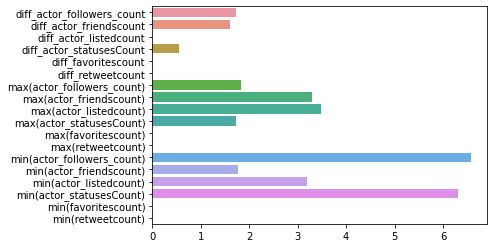

In [233]:

rf_classifier = rf_with_text_model.stages[-1]
f = sns.barplot(x= rf_classifier.featureImportances.toArray()[:18]*100, y=cols[:18])

In [178]:
# get the hash of every word to we can interpret the feature vector coming from tfidf
ndf = traindatset.select('lonely_indicator',F.explode('token_features').name('expwords')).withColumn('token_features',F.array('expwords'))
hashudf = F.udf(lambda vector : vector.indices.tolist()[0],T.StringType())
wordtf = tdfidf_model.stages[-2].transform(ndf).withColumn('wordhash',hashudf(F.col('rawFeatures')))
# wordtf.show()

In [179]:
wordtf.show(2)

+----------------+--------+--------------+-----------------+--------+
|lonely_indicator|expwords|token_features|      rawFeatures|wordhash|
+----------------+--------+--------------+-----------------+--------+
|             1.0| olya_78|     [olya_78]|(400,[117],[1.0])|     117|
|             1.0|    home|        [home]|(400,[165],[1.0])|     165|
+----------------+--------+--------------+-----------------+--------+
only showing top 2 rows



In [180]:

# get every word hash against it's word
union = F.udf(lambda x,y: str(x)+" " +str(y)  )
dt = wordtf.select(['wordhash','token_features']).rdd.map(lambda x: (x[0], x[1])).reduceByKey(lambda x,y: x+y)
word_data = dt.collect()
dd = pd.DataFrame(word_data,columns=['key','val'])
dd['key'] = dd['key'].apply(lambda x:int(x))
dd.set_index('key',inplace=True)

In [182]:
# get the words features importance from the feature importance array sort it by value
rf_classifier = rf_with_text_model.stages[-1]
featues_import = pd.DataFrame(rf_classifier.featureImportances.values[18:],index= rf_classifier.featureImportances.indices[18:],columns=['value'])
dc  = featues_import.join(dd)
dc = dc.fillna(value=0).sort_values(by='value', ascending=False)
# dc.fillna(value=0,inplace=True)
dc.sort_values(by='value', ascending=False,inplace=True)


In [184]:
#add coulms to display words against their importance
new_cols = cols[:18]
from collections import Counter

for l in dc['val'][:50]:
    words = ""
    if not isinstance(l, int):
        counter = Counter(l)
        most_occur = counter.most_common(4)
        col = ""
        for w,i in most_occur:
            col = col+" "+w+" "+str(i)+" "
            
        new_cols.append(col)
# f_importances = np.concatenate([rf_classifier.featureImportances.values[:18], dc[:1]['value']])

In [185]:
f_importances = np.concatenate([rf_classifier.featureImportances.values[:18], dc[:40]['value']])
# how important that features as percentage
f_importances.sum()  # importance of the first 18 features plus 40 features from the agg_text vectorized form

0.7816488313757634

In [186]:
f_importances[:18].sum() # importance of the first 18 features

0.3548932949750546

<AxesSubplot:>

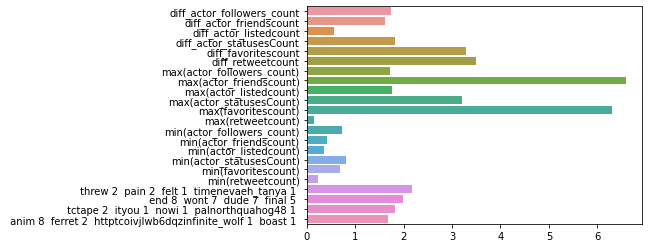

In [187]:
# featues_import.sort_values(by='value',ascending=False)
sns.barplot(x=f_importances[:22]*100 , y=new_cols[:22])


In [241]:
rf_classifier = rf_with_text_model.stages[-1]
f_import = rf_classifier.featureImportances.toArray()[:18]
new_cols = np.array(cols[:18])[np.argsort(f_import)[::-1]][:5] # get the most important columns

In [242]:
new_cols = list(new_cols)
new_cols.append('features1')
assembler1 = VectorAssembler(inputCols=new_cols, outputCol='features')
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'lonely_indicator',seed=42)
rf.setWeightCol('classWeights')

RandomForestClassifier_1353430f48c8

In [243]:
rf_with_text  = Pipeline(
    stages=[assembler1,rf])
rf_with_text_model = rf_with_text.fit(traindatset)
predictions_text_5 =  rf_with_text_model.transform(testdataset)
predictions_text_5.groupby(["prediction","lonely_indicator"]).count().show()

+----------+----------------+-----+
|prediction|lonely_indicator|count|
+----------+----------------+-----+
|       1.0|             1.0|  110|
|       0.0|             1.0|   14|
|       1.0|             0.0|   21|
|       0.0|             0.0|    4|
+----------+----------------+-----+



In [244]:
preds_text = predictions_text.select(["lonely_indicator","prediction"]).toPandas()
preds_text_5 = predictions_text_5.select(["lonely_indicator","prediction"]).toPandas()

print("using all the 18 features and with using the text column\n")
print (classification_report( preds_text["lonely_indicator"],preds_text["prediction"],zero_division='warn'))
print("using all the 5 most important features of the 18 and with using the text column\n")
print (classification_report( preds_text_5["lonely_indicator"],preds_text_5["prediction"],zero_division='warn'))

using all the 18 features and with using the text column

              precision    recall  f1-score   support

         0.0       0.25      0.20      0.22        25
         1.0       0.84      0.88      0.86       124

    accuracy                           0.77       149
   macro avg       0.55      0.54      0.54       149
weighted avg       0.75      0.77      0.75       149

using all the 5 most important features of the 18 and with using the text column

              precision    recall  f1-score   support

         0.0       0.22      0.16      0.19        25
         1.0       0.84      0.89      0.86       124

    accuracy                           0.77       149
   macro avg       0.53      0.52      0.52       149
weighted avg       0.74      0.77      0.75       149



In [144]:
# vectorize the agg_text using the word2vector model
w2_v = Word2Vec(vectorSize=6, seed=42, inputCol="token_features", outputCol="v_embbeding")

In [145]:
w2_v_model = w2_v.fit(traindatset)
traindatset  = w2_v_model.transform(traindatset) # transform the agg_text column
testdataset  = w2_v_model.transform(testdataset)

In [146]:
newcols = cols[:18]
newcols.append('v_embbeding')
assembler1 = VectorAssembler(inputCols=newcols, outputCol='features')
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'lonely_indicator',seed=42)
rf.setWeightCol('classWeights')


RandomForestClassifier_ff8e95ae1093

In [147]:
rf_wv  = Pipeline(
    stages=[assembler1,rf])
rf_wv_model = rf_wv.fit(traindatset)
predictions =  rf_wv_model.transform(testdataset)
predictions.groupby(["prediction","lonely_indicator"]).count().show()

+----------+----------------+-----+
|prediction|lonely_indicator|count|
+----------+----------------+-----+
|       1.0|             1.0|  112|
|       0.0|             1.0|   12|
|       1.0|             0.0|   20|
|       0.0|             0.0|    5|
+----------+----------------+-----+



In [148]:
preds = predictions.select(["lonely_indicator","prediction"]).toPandas()
print (classification_report( preds["lonely_indicator"],preds["prediction"],zero_division='warn'))

              precision    recall  f1-score   support

         0.0       0.29      0.20      0.24        25
         1.0       0.85      0.90      0.88       124

    accuracy                           0.79       149
   macro avg       0.57      0.55      0.56       149
weighted avg       0.76      0.79      0.77       149



In [994]:
# rf_classifier = rf_wv_model.stages[-1]
# sns.barplot(x=rf_classifier.featureImportances.values[:15] , y=cols[:15])


In [229]:
# ff = F.udf(lambda x:x[0],T.StringType())
# words = wordtf.withColumn('token_features',ff('token_features'))

1772

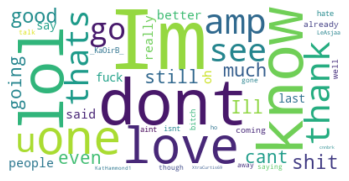

In [131]:
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# evaluator = MulticlassClassificationEvaluator(labelCol="lonely_indicator", predictionCol="prediction",metricLabel=1.0, metricName="weightedPrecision")
# accuracy = evaluator.evaluate(predictions)
# print("Accuracy = %g" % (accuracy))
# print("Test Error = %g " % (1.0 - accuracy))

In [976]:
# from pyspark.mllib.evaluation import MulticlassMetrics
# from pyspark.sql.types import FloatType
# import pyspark.sql.functions as F
# import pandas as pd
# preds_and_labels = predictions.select(['prediction','lonely_indicator']).withColumn('lonely_indicator', F.col('lonely_indicator').cast(FloatType())).orderBy('prediction')
# preds_and_labels = preds_and_labels.select(['prediction','lonely_indicator'])
# metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
# # print(metrics.confusionMatrix().toArray())
# conf_matrix = pd.DataFrame(metrics.confusionMatrix().toArray(),columns=['class0','class1'])
# conf_matrix['index'] = ['class0','class1']


In [975]:
# conf_matrix.set_index('index')

In [973]:
# from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# from pyspark.ml.evaluation import BinaryClassificationEvaluator
# rfevaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="lonely_indicator",metricName= "f1")

# # Create ParamGrid for Cross Validation
# rfparamGrid = (ParamGridBuilder()
#              #.addGrid(rf.maxDepth, [2, 5, 10, 20, 30])
#                .addGrid(rf.maxDepth, [2, 5, 10])
#              #.addGrid(rf.maxBins, [10, 20, 40, 80, 100])
#                .addGrid(rf.maxBins, [5, 10, 20])
#              #.addGrid(rf.numTrees, [5, 20, 50, 100, 500])
#                .addGrid(rf.numTrees, [5, 20, 50])
#              .build())

# # Create 5-fold CrossValidator
# rfcv = CrossValidator(estimator = rf_pip,
#                       estimatorParamMaps = rfparamGrid,
#                       evaluator = rfevaluator,
#                       numFolds = 2)


In [465]:
# rfcvModel = rfcv.fit(traindatset)

In [254]:
# rfpredictions = rfcvModel.transform(testdataset)


In [543]:
# from sklearn.metrics import classification_report
# preds = rfpredictions.select(["lonely_indicator","prediction"]).toPandas()
# print (classification_report( preds["lonely_indicator"],preds["prediction"],zero_division='warn'))

In [974]:
# testdataset = testdataset.withColumn("classWeights", F.when(testdataset.lonely_indicator == 0,BalancingRatio).otherwise(1-BalancingRatio))
